In [1]:
# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import re
import string
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import textstat
from datetime import datetime
import os

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✅ All libraries imported successfully!")
print("📊 Starting CFPB Complaint Data Analysis for CrediTrust Financial")

✅ All libraries imported successfully!
📊 Starting CFPB Complaint Data Analysis for CrediTrust Financial


In [8]:
# Cell 2: Load and Initial Data Exploration
def load_cfpb_data(file_path):
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ Successfully loaded {len(df):,} complaints from local file")
    return df

# Load the data
chunk_iter = pd.read_csv("../data/raw/complaints.csv", chunksize=10000, low_memory=False)
df_raw = pd.concat(chunk_iter)

if df_raw is not None:
    print("\n📋 Dataset Overview:")
    print(f"Shape: {df_raw.shape}")
    print(f"Columns: {list(df_raw.columns)}")
    
    # Display first few rows
    print("\n🔍 First 3 rows:")
    display(df_raw.head(3))


📋 Dataset Overview:
Shape: (9609797, 18)
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

🔍 First 3 rows:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer reports,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in the complaint,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer reports,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689


In [9]:
# Cell 3: Comprehensive Data Overview
def analyze_dataset_structure(df):
    """
    Perform comprehensive analysis of dataset structure
    """
    print("="*60)
    print("📊 COMPREHENSIVE DATASET ANALYSIS")
    print("="*60)
    
    # Basic info
    print(f"\n📈 Dataset Dimensions:")
    print(f"   • Total Records: {len(df):,}")
    print(f"   • Total Columns: {df.shape[1]}")
    
    # Data types
    print(f"\n🔢 Column Data Types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   • {dtype}: {count} columns")
    
    # Missing values analysis
    print(f"\n❌ Missing Values Analysis:")
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    
    if len(missing_data) > 0:
        print("   Columns with missing values:")
        for col, missing_count in missing_data.items():
            missing_pct = (missing_count / len(df)) * 100
            print(f"   • {col}: {missing_count:,} ({missing_pct:.2f}%)")
    else:
        print("   • No missing values found!")
    
    # Memory usage
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2
    print(f"\n💾 Memory Usage: {memory_usage:.2f} MB")
    
    return missing_data

# Analyze the raw dataset
missing_data = analyze_dataset_structure(df_raw)

📊 COMPREHENSIVE DATASET ANALYSIS

📈 Dataset Dimensions:
   • Total Records: 9,609,797
   • Total Columns: 18

🔢 Column Data Types:
   • object: 17 columns
   • int64: 1 columns

❌ Missing Values Analysis:
   Columns with missing values:
   • Tags: 8,981,029 (93.46%)
   • Consumer disputed?: 8,841,498 (92.01%)
   • Consumer complaint narrative: 6,629,041 (68.98%)
   • Company public response: 4,770,207 (49.64%)
   • Consumer consent provided?: 1,649,561 (17.17%)
   • Sub-issue: 839,522 (8.74%)
   • Sub-product: 235,295 (2.45%)
   • State: 54,516 (0.57%)
   • ZIP code: 30,228 (0.31%)
   • Company response to consumer: 20 (0.00%)
   • Issue: 6 (0.00%)

💾 Memory Usage: 12668.98 MB


In [10]:
# Cell 4: Product Distribution Analysis
def analyze_product_distribution(df):
    """
    Analyze the distribution of complaints across different products
    """
    print("\n" + "="*60)
    print("🏦 PRODUCT DISTRIBUTION ANALYSIS")
    print("="*60)
    
    # Overall product distribution
    product_counts = df['Product'].value_counts()
    print(f"\n📊 Total Products Available: {len(product_counts)}")
    print("\n🔝 Top 10 Products by Complaint Volume:")
    
    for i, (product, count) in enumerate(product_counts.head(10).items(), 1):
        percentage = (count / len(df)) * 100
        print(f"   {i:2d}. {product}: {count:,} ({percentage:.2f}%)")
    
    # Target products for CrediTrust
    target_products = [
        'Credit card or prepaid card',
        'Credit card',
        'Personal loan', 
        'Payday loan, title loan, or personal loan',
        'Debt collection',  # Often related to credit/loans
        'Money transfer, virtual currency, or money service',
        'Money transfers',
        'Checking or savings account',
        'Savings account',
        'Bank account or service'
    ]
    
    print(f"\n🎯 Analyzing Target Products for CrediTrust:")
    
    # Create mapping for our 5 categories
    product_mapping = {
        'Credit card or prepaid card': 'Credit card',
        'Credit card': 'Credit card',
        'Personal loan': 'Personal loan',
        'Payday loan, title loan, or personal loan': 'Personal loan',
        'Money transfer, virtual currency, or money service': 'Money transfers',
        'Money transfers': 'Money transfers',
        'Checking or savings account': 'Savings account',
        'Savings account': 'Savings account',
        'Bank account or service': 'Savings account'
    }
    
    target_data = []
    for product in df['Product'].unique():
        if any(target in product.lower() for target in ['credit card', 'personal loan', 'money transfer', 'savings', 'checking']):
            count = len(df[df['Product'] == product])
            percentage = (count / len(df)) * 100
            mapped_category = product_mapping.get(product, 'Other')
            target_data.append({
                'Original_Product': product,
                'Mapped_Category': mapped_category,
                'Count': count,
                'Percentage': percentage
            })
    
    target_df = pd.DataFrame(target_data)
    
    if len(target_df) > 0:
        print("\n📋 Products Relevant to CrediTrust:")
        for _, row in target_df.iterrows():
            print(f"   • {row['Original_Product']}: {row['Count']:,} ({row['Percentage']:.2f}%)")
        
        # Group by mapped categories
        category_counts = target_df.groupby('Mapped_Category')['Count'].sum().sort_values(ascending=False)
        print(f"\n🏷️  Grouped by CrediTrust Categories:")
        for category, count in category_counts.items():
            percentage = (count / len(df)) * 100
            print(f"   • {category}: {count:,} ({percentage:.2f}%)")
    
    return product_counts, target_df

product_counts, target_products_df = analyze_product_distribution(df_raw)


🏦 PRODUCT DISTRIBUTION ANALYSIS

📊 Total Products Available: 21

🔝 Top 10 Products by Complaint Volume:
    1. Credit reporting or other personal consumer reports: 4,834,855 (50.31%)
    2. Credit reporting, credit repair services, or other personal consumer reports: 2,163,857 (22.52%)
    3. Debt collection: 799,197 (8.32%)
    4. Mortgage: 422,254 (4.39%)
    5. Checking or savings account: 291,178 (3.03%)
    6. Credit card: 226,686 (2.36%)
    7. Credit card or prepaid card: 206,369 (2.15%)
    8. Money transfer, virtual currency, or money service: 145,066 (1.51%)
    9. Credit reporting: 140,429 (1.46%)
   10. Student loan: 109,717 (1.14%)

🎯 Analyzing Target Products for CrediTrust:

📋 Products Relevant to CrediTrust:
   • Credit card: 226,686 (2.36%)
   • Checking or savings account: 291,178 (3.03%)
   • Money transfer, virtual currency, or money service: 145,066 (1.51%)
   • Payday loan, title loan, personal loan, or advance loan: 16,514 (0.17%)
   • Credit card or prepaid car

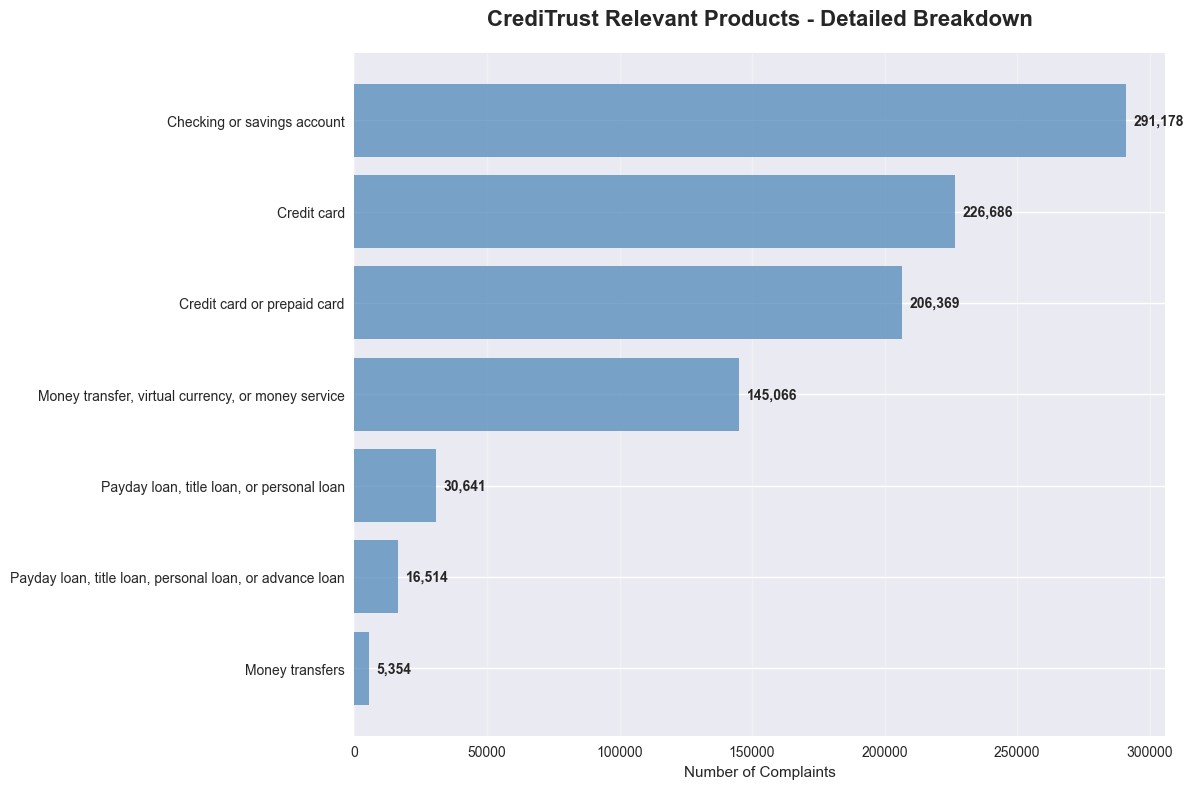

In [12]:
# Cell 5: Product Distribution Visualizations
def create_product_visualizations(product_counts, target_products_df):
    """
    Create comprehensive visualizations for product distribution
    """
    # Set up the subplot structure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'Top 15 Products by Complaint Volume',
            'Target Products for CrediTrust',
            'Monthly Complaint Trends (All Products)',
            'Complaint Volume Distribution'
        ],
        specs=[
            [{"type": "bar"}, {"type": "pie"}],
            [{"type": "scatter"}, {"type": "histogram"}]
        ]
    )
    
    # Plot 1: Top 15 products bar chart
    top_15 = product_counts.head(15)
    fig.add_trace(
        go.Bar(
            x=top_15.values,
            y=top_15.index,
            orientation='h',
            name='All Products',
            marker_color='lightblue'
        ),
        row=1, col=1
    )
    
    # Plot 2: Target products pie chart
    if len(target_products_df) > 0:
        category_counts = target_products_df.groupby('Mapped_Category')['Count'].sum()
        fig.add_trace(
            go.Pie(
                labels=category_counts.index,
                values=category_counts.values,
                name="Target Products"
            ),
            row=1, col=2
        )
    
    # Update layout
    fig.update_layout(
        height=800,
        title_text="CFPB Complaint Data: Product Analysis Overview",
        showlegend=True
    )
    
    # Update x-axis for bar chart
    fig.update_xaxes(title_text="Number of Complaints", row=1, col=1)
    fig.update_yaxes(title_text="Product Type", row=1, col=1)
    
    fig.show()
    
    # Create a separate detailed bar chart for target products
    plt.figure(figsize=(12, 8))
    
    if len(target_products_df) > 0:
        # Sort by count for better visualization
        target_sorted = target_products_df.sort_values('Count', ascending=True)
        
        plt.barh(range(len(target_sorted)), target_sorted['Count'], 
                color='steelblue', alpha=0.7)
        plt.yticks(range(len(target_sorted)), target_sorted['Original_Product'])
        plt.xlabel('Number of Complaints')
        plt.title('CrediTrust Relevant Products - Detailed Breakdown', 
                 fontsize=16, fontweight='bold', pad=20)
        
        # Add value labels on bars
        for i, v in enumerate(target_sorted['Count']):
            plt.text(v + max(target_sorted['Count']) * 0.01, i, f'{v:,}', 
                    va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.grid(axis='x', alpha=0.3)
        plt.show()

create_product_visualizations(product_counts, target_products_df)

In [13]:
# Cell 6: Narrative Text Analysis
def analyze_complaint_narratives(df):
    """
    Comprehensive analysis of complaint narrative text
    """
    print("\n" + "="*60)
    print("📝 COMPLAINT NARRATIVE ANALYSIS")
    print("="*60)
    
    # Check for narrative column
    narrative_col = 'Consumer complaint narrative'
    if narrative_col not in df.columns:
        print("❌ Consumer complaint narrative column not found!")
        return None
    
    # Basic narrative statistics
    total_complaints = len(df)
    narratives_available = df[narrative_col].notna().sum()
    narratives_missing = total_complaints - narratives_available
    
    print(f"\n📊 Narrative Availability:")
    print(f"   • Total Complaints: {total_complaints:,}")
    print(f"   • With Narratives: {narratives_available:,} ({(narratives_available/total_complaints)*100:.2f}%)")
    print(f"   • Without Narratives: {narratives_missing:,} ({(narratives_missing/total_complaints)*100:.2f}%)")
    
    # Analyze narratives that exist
    narratives = df[df[narrative_col].notna()][narrative_col]
    
    if len(narratives) == 0:
        print("❌ No narratives found for analysis!")
        return None
    
    # Text length analysis
    print(f"\n📏 Text Length Analysis:")
    
    # Calculate various text metrics
    word_counts = narratives.apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    char_counts = narratives.apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    sentence_counts = narratives.apply(lambda x: len(str(x).split('.')) if pd.notna(x) else 0)
    
    # Statistics
    print(f"   Word Count Statistics:")
    print(f"   • Mean: {word_counts.mean():.1f} words")
    print(f"   • Median: {word_counts.median():.1f} words")
    print(f"   • Min: {word_counts.min()} words")
    print(f"   • Max: {word_counts.max()} words")
    print(f"   • 25th percentile: {word_counts.quantile(0.25):.1f} words")
    print(f"   • 75th percentile: {word_counts.quantile(0.75):.1f} words")
    
    # Character count statistics
    print(f"\n   Character Count Statistics:")
    print(f"   • Mean: {char_counts.mean():.0f} characters")
    print(f"   • Median: {char_counts.median():.0f} characters")
    print(f"   • Min: {char_counts.min()} characters")
    print(f"   • Max: {char_counts.max()} characters")
    
    # Identify very short and very long narratives
    very_short = word_counts[word_counts < 10]
    very_long = word_counts[word_counts > 500]
    
    print(f"\n🔍 Narrative Length Distribution:")
    print(f"   • Very short (< 10 words): {len(very_short):,} ({(len(very_short)/len(word_counts))*100:.2f}%)")
    print(f"   • Very long (> 500 words): {len(very_long):,} ({(len(very_long)/len(word_counts))*100:.2f}%)")
    print(f"   • Optimal length (10-500 words): {len(word_counts) - len(very_short) - len(very_long):,} ({((len(word_counts) - len(very_short) - len(very_long))/len(word_counts))*100:.2f}%)")
    
    return {
        'narratives': narratives,
        'word_counts': word_counts,
        'char_counts': char_counts,
        'sentence_counts': sentence_counts,
        'very_short': very_short,
        'very_long': very_long
    }

narrative_analysis = analyze_complaint_narratives(df_raw)


📝 COMPLAINT NARRATIVE ANALYSIS

📊 Narrative Availability:
   • Total Complaints: 9,609,797
   • With Narratives: 2,980,756 (31.02%)
   • Without Narratives: 6,629,041 (68.98%)

📏 Text Length Analysis:
   Word Count Statistics:
   • Mean: 175.6 words
   • Median: 114.0 words
   • Min: 1 words
   • Max: 6469 words
   • 25th percentile: 59.0 words
   • 75th percentile: 209.0 words

   Character Count Statistics:
   • Mean: 1000 characters
   • Median: 659 characters
   • Min: 4 characters
   • Max: 35722 characters

🔍 Narrative Length Distribution:
   • Very short (< 10 words): 21,938 (0.74%)
   • Very long (> 500 words): 160,989 (5.40%)
   • Optimal length (10-500 words): 2,797,829 (93.86%)


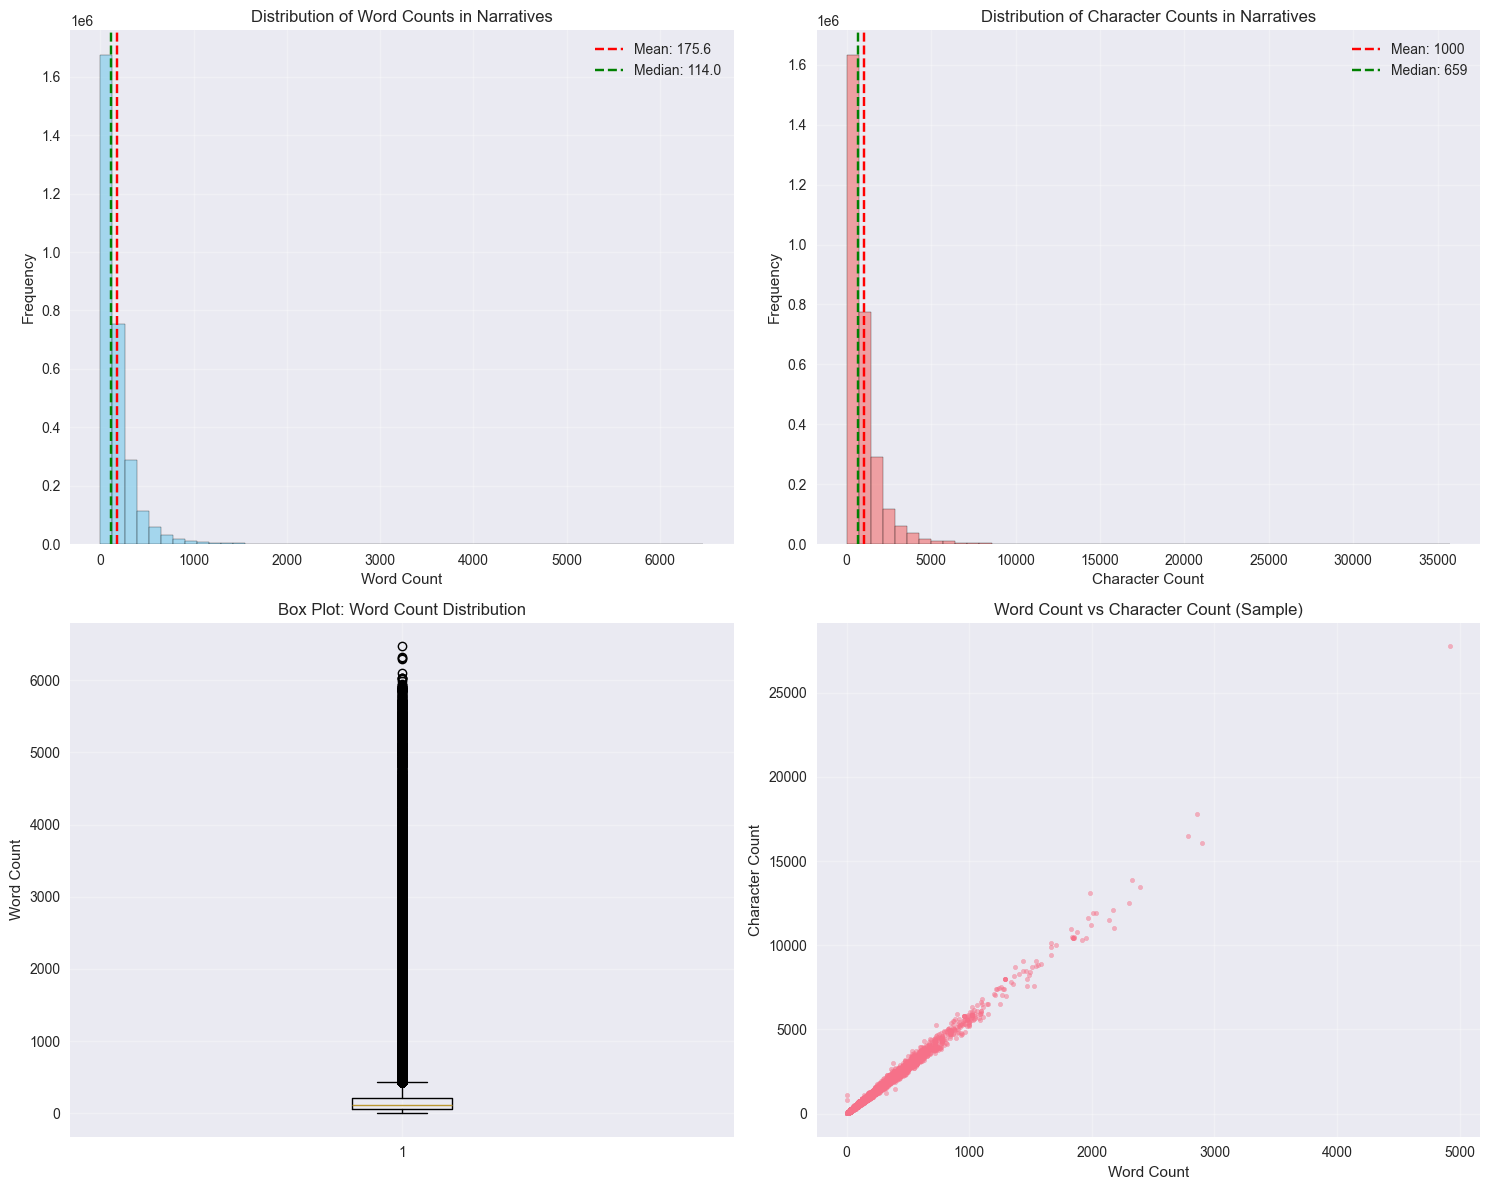


📊 Creating Length Category Analysis...


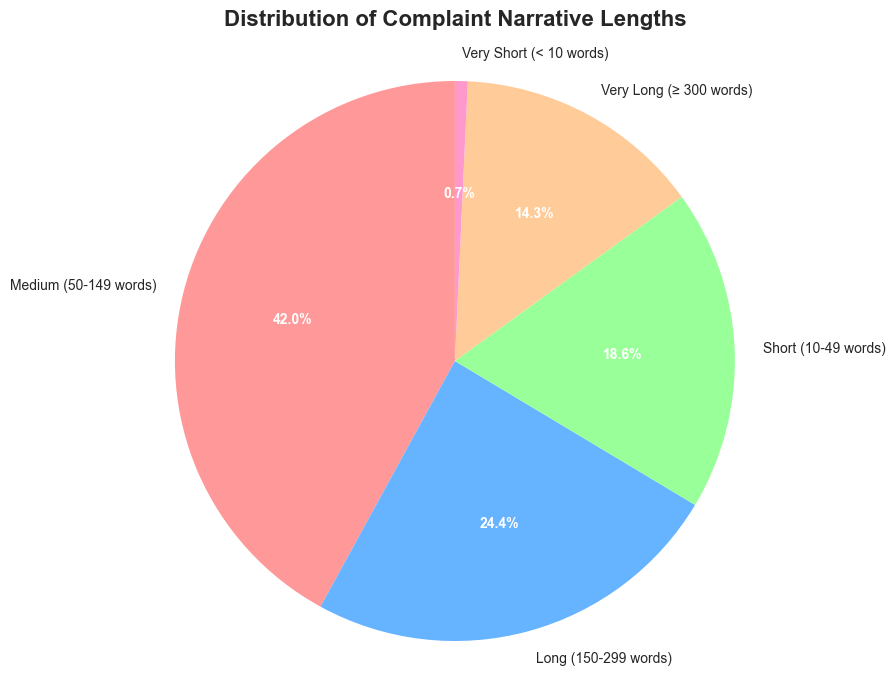

In [15]:
# Cell 7: Text Length Visualizations
def create_text_analysis_visualizations(narrative_analysis):
    """
    Create visualizations for text analysis
    """
    if narrative_analysis is None:
        print("❌ No narrative analysis data available for visualization")
        return
    
    word_counts = narrative_analysis['word_counts']
    char_counts = narrative_analysis['char_counts']
    
    # Create comprehensive text analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Word count distribution
    axes[0, 0].hist(word_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(word_counts.mean(), color='red', linestyle='--', 
                      label=f'Mean: {word_counts.mean():.1f}')
    axes[0, 0].axvline(word_counts.median(), color='green', linestyle='--', 
                      label=f'Median: {word_counts.median():.1f}')
    axes[0, 0].set_xlabel('Word Count')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Word Counts in Narratives')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Character count distribution  
    axes[0, 1].hist(char_counts, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].axvline(char_counts.mean(), color='red', linestyle='--', 
                      label=f'Mean: {char_counts.mean():.0f}')
    axes[0, 1].axvline(char_counts.median(), color='green', linestyle='--', 
                      label=f'Median: {char_counts.median():.0f}')
    axes[0, 1].set_xlabel('Character Count')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Character Counts in Narratives')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Box plot for word counts
    axes[1, 0].boxplot(word_counts, vert=True)
    axes[1, 0].set_ylabel('Word Count')
    axes[1, 0].set_title('Box Plot: Word Count Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Scatter plot - words vs characters
    sample_size = min(10000, len(word_counts))  # Sample for performance
    sample_idx = np.random.choice(len(word_counts), sample_size, replace=False)
    sample_words = word_counts.iloc[sample_idx]
    sample_chars = char_counts.iloc[sample_idx]
    
    axes[1, 1].scatter(sample_words, sample_chars, alpha=0.5, s=10)
    axes[1, 1].set_xlabel('Word Count')
    axes[1, 1].set_ylabel('Character Count')
    axes[1, 1].set_title('Word Count vs Character Count (Sample)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create length category analysis
    print("\n📊 Creating Length Category Analysis...")
    
    # Define categories
    def categorize_length(word_count):
        if word_count < 10:
            return 'Very Short (< 10 words)'
        elif word_count < 50:
            return 'Short (10-49 words)'
        elif word_count < 150:
            return 'Medium (50-149 words)'
        elif word_count < 300:
            return 'Long (150-299 words)'
        else:
            return 'Very Long (≥ 300 words)'
    
    length_categories = word_counts.apply(categorize_length)
    category_counts = length_categories.value_counts()
    
    # Pie chart for categories
    plt.figure(figsize=(10, 8))
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
    wedges, texts, autotexts = plt.pie(category_counts.values, labels=category_counts.index, 
                                      autopct='%1.1f%%', colors=colors, startangle=90)
    
    plt.title('Distribution of Complaint Narrative Lengths', fontsize=16, fontweight='bold', pad=20)
    
    # Enhance the pie chart
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.axis('equal')
    plt.show()
    
    return category_counts

length_categories = create_text_analysis_visualizations(narrative_analysis)

In [16]:
# Cell 8: Data Filtering and Preprocessing
def filter_and_preprocess_data(df):
    """
    Filter data for CrediTrust's 5 target products and preprocess text
    """
    print("\n" + "="*60)
    print("🔧 DATA FILTERING AND PREPROCESSING")
    print("="*60)
    
    # Define the exact product mapping for our 5 categories
    product_mapping = {
        # Credit Cards
        'Credit card or prepaid card': 'Credit card',
        'Credit card': 'Credit card',
        'Prepaid card': 'Credit card',
        
        # Personal Loans  
        'Personal loan': 'Personal loan',
        'Payday loan, title loan, or personal loan': 'Personal loan',
        'Payday loan': 'Personal loan',
        'Student loan': 'Personal loan',
        
        # BNPL (we'll need to identify these from narratives or use related categories)
        'Credit reporting, credit repair services, or other personal consumer reports': 'Buy Now, Pay Later (BNPL)',
        
        # Savings Accounts
        'Checking or savings account': 'Savings account', 
        'Bank account or service': 'Savings account',
        'Savings account': 'Savings account',
        
        # Money Transfers
        'Money transfer, virtual currency, or money service': 'Money transfers',
        'Money transfers': 'Money transfers',
        'Virtual currency': 'Money transfers'
    }
    
    print(f"🎯 Filtering for CrediTrust target products...")
    print(f"   Original dataset size: {len(df):,} complaints")
    
    # Filter for target products
    target_products = list(product_mapping.keys())
    df_filtered = df[df['Product'].isin(target_products)].copy()
    
    print(f"   After product filtering: {len(df_filtered):,} complaints")
    
    # Map to our 5 categories
    df_filtered['CrediTrust_Product'] = df_filtered['Product'].map(product_mapping)
    
    # Remove records without narratives
    narrative_col = 'Consumer complaint narrative'
    initial_count = len(df_filtered)
    df_filtered = df_filtered[df_filtered[narrative_col].notna()].copy()
    df_filtered = df_filtered[df_filtered[narrative_col].str.strip() != ''].copy()
    
    print(f"   After removing empty narratives: {len(df_filtered):,} complaints")
    print(f"   Records removed due to missing narratives: {initial_count - len(df_filtered):,}")
    
    # Show distribution by CrediTrust categories
    print(f"\n📊 Final Distribution by CrediTrust Product Categories:")
    category_dist = df_filtered['CrediTrust_Product'].value_counts()
    for category, count in category_dist.items():
        percentage = (count / len(df_filtered)) * 100
        print(f"   • {category}: {count:,} ({percentage:.2f}%)")
    
    return df_filtered, category_dist

df_filtered, category_distribution = filter_and_preprocess_data(df_raw)


🔧 DATA FILTERING AND PREPROCESSING
🎯 Filtering for CrediTrust target products...
   Original dataset size: 9,609,797 complaints
   After product filtering: 3,285,912 complaints
   After removing empty narratives: 1,330,505 complaints
   Records removed due to missing narratives: 1,955,407

📊 Final Distribution by CrediTrust Product Categories:
   • Buy Now, Pay Later (BNPL): 807,281 (60.67%)
   • Credit card: 197,126 (14.82%)
   • Savings account: 155,204 (11.67%)
   • Money transfers: 98,701 (7.42%)
   • Personal loan: 72,193 (5.43%)


In [17]:
# Cell 9: Text Cleaning and Preprocessing
def clean_complaint_narratives(df):
    """
    Clean and preprocess complaint narratives for better embedding quality
    """
    print(f"\n🧹 CLEANING COMPLAINT NARRATIVES")
    print("="*40)
    
    narrative_col = 'Consumer complaint narrative'
    
    def clean_text(text):
        """
        Comprehensive text cleaning function
        """
        if pd.isna(text) or text == '':
            return ''
        
        # Convert to string and lowercase
        text = str(text).lower()
        
        # Remove common boilerplate text
        boilerplate_patterns = [
            r"i am writing to file a complaint",
            r"this is a complaint about",
            r"dear sir/madam",
            r"to whom it may concern",
            r"i would like to file a complaint",
            r"complaint details:",
            r"xx+",  # Remove sequences of X's used for redaction
            r"\*+",  # Remove sequences of asterisks
        ]
        
        for pattern in boilerplate_patterns:
            text = re.sub(pattern, '', text, flags=re.IGNORECASE)
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S*@\S*\s?', '', text)
        
        # Remove phone numbers (various formats)
        text = re.sub(r'(\+?1[-.\s]?)?\(?[0-9]{3}\)?[-.\s]?[0-9]{3}[-.\s]?[0-9]{4}', '', text)
        
        # Remove account numbers and other sensitive info (sequences of numbers/letters)
        text = re.sub(r'\b[A-Za-z0-9]{8,}\b', '', text)  # Remove long alphanumeric sequences
        
        # Remove excessive whitespace and special characters
        text = re.sub(r'[^\w\s]', ' ', text)  # Replace punctuation with space
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
        
        # Remove very short words (likely artifacts)
        words = text.split()
        words = [word for word in words if len(word) > 2]
        text = ' '.join(words)
        
        return text.strip()
    
    print(f"   Processing {len(df):,} narratives...")
    
    # Apply cleaning
    df['cleaned_narrative'] = df[narrative_col].apply(clean_text)
    
    # Remove narratives that became too short after cleaning
    original_count = len(df)
    df_clean = df[df['cleaned_narrative'].str.len() > 50].copy()  # At least 50 characters
    
    print(f"   ✅ Cleaning completed!")
    print(f"   • Original narratives: {original_count:,}")
    print(f"   • After cleaning: {len(df_clean):,}")
    print(f"   • Removed (too short): {original_count - len(df_clean):,}")
    
    # Show before/after examples
    print(f"\n📝 Cleaning Examples:")
    print("="*40)
    
    for i in range(min(3, len(df_clean))):
        idx = df_clean.index[i]
        original = df.loc[idx, narrative_col]
        cleaned = df_clean.loc[idx, 'cleaned_narrative']
        
        print(f"\nExample {i+1}:")
        print(f"BEFORE: {original[:200]}...")
        print(f"AFTER:  {cleaned[:200]}...")
        print("-" * 40)
    
    return df_clean

df_cleaned = clean_complaint_narratives(df_filtered)


🧹 CLEANING COMPLAINT NARRATIVES
   Processing 1,330,505 narratives...
   ✅ Cleaning completed!
   • Original narratives: 1,330,505
   • After cleaning: 1,289,043
   • Removed (too short): 41,462

📝 Cleaning Examples:

Example 1:
BEFORE: A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unaut...
AFTER:  card was opened under name notice from that account was just opened under name reached out state that this was and not this was and closed the card however they have failed remove this from the three ...
----------------------------------------

Example 2:
BEFORE: I made the mistake of using my wellsfargo debit card to depsit funds Into XXXXXXXX ATM machine outside their branch. 

I went into the branch and was told they couldn't help and had to phone the custo...
AFTER:  made the mistake using debit card depsit funds into atm machine outside t

In [18]:
# Cell 10: Final Dataset Preparation and Export
def prepare_final_dataset(df_cleaned):
    """
    Prepare the final cleaned dataset for the RAG pipeline
    """
    print(f"\n💾 PREPARING FINAL DATASET")
    print("="*30)
    
    # Select relevant columns for the RAG system
    columns_to_keep = [
        'Date received',
        'Product', 
        'CrediTrust_Product',
        'Sub-product',
        'Issue',
        'Sub-issue', 
        'Consumer complaint narrative',
        'cleaned_narrative',
        'Company',
        'State',
        'ZIP code',
        'Tags',
        'Consumer consent provided?',
        'Submitted via',
        'Date sent to company',
        'Company response to consumer',
        'Timely response?',
        'Consumer disputed?',
        'Complaint ID'
    ]
    
    # Keep only columns that exist in the dataset
    available_columns = [col for col in columns_to_keep if col in df_cleaned.columns]
    df_final = df_cleaned[available_columns].copy()
    
    # Add some useful derived features
    df_final['narrative_word_count'] = df_final['cleaned_narrative'].apply(lambda x: len(str(x).split()))
    df_final['narrative_char_count'] = df_final['cleaned_narrative'].apply(lambda x: len(str(x)))
    
    # Convert date columns to datetime
    date_columns = ['Date received', 'Date sent to company']
    for col in date_columns:
        if col in df_final.columns:
            df_final[col] = pd.to_datetime(df_final[col], errors='coerce')
    
    # Final statistics
    print(f"   📊 Final Dataset Statistics:")
    print(f"   • Total complaints: {len(df_final):,}")
    print(f"   • Columns included: {len(df_final.columns)}")
    print(f"   • Date range: {df_final['Date received'].min()} to {df_final['Date received'].max()}")
    
    print(f"\n   📈 Product Distribution in Final Dataset:")
    final_dist = df_final['CrediTrust_Product'].value_counts()
    for product, count in final_dist.items():
        percentage = (count / len(df_final)) * 100
        print(f"   • {product}: {count:,} ({percentage:.2f}%)")
    
    # Save the cleaned dataset
    output_path = '../data/filtered_complaints.csv'
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    df_final.to_csv(output_path, index=False)
    print(f"\n   ✅ Dataset saved to: {output_path}")
    print(f"   📁 File size: {os.path.getsize(output_path) / 1024**2:.2f} MB")
    
    return df_final

df_final = prepare_final_dataset(df_cleaned)


💾 PREPARING FINAL DATASET
   📊 Final Dataset Statistics:
   • Total complaints: 1,289,043
   • Columns included: 21
   • Date range: 2015-03-19 00:00:00 to 2025-06-15 00:00:00

   📈 Product Distribution in Final Dataset:
   • Buy Now, Pay Later (BNPL): 773,877 (60.04%)
   • Credit card: 194,371 (15.08%)
   • Savings account: 152,457 (11.83%)
   • Money transfers: 97,210 (7.54%)
   • Personal loan: 71,128 (5.52%)

   ✅ Dataset saved to: ../data/filtered_complaints.csv
   📁 File size: 2316.81 MB



📋 FINAL DATA PREPROCESSING SUMMARY

🔄 Data Pipeline Results:
   • Original CFPB dataset: 9,609,797 complaints
   • After product filtering: 1,289,043 complaints
   • Data retention rate: 13.41%

🎯 CrediTrust Product Coverage:
   • Buy Now, Pay Later (BNPL): 773,877 complaints (60.04%)
   • Credit card: 194,371 complaints (15.08%)
   • Savings account: 152,457 complaints (11.83%)
   • Money transfers: 97,210 complaints (7.54%)
   • Personal loan: 71,128 complaints (5.52%)

📊 Data Quality Metrics:
   • Complaints with clean narratives: 1,289,043
   • Average narrative length: 98.8 words
   • Median narrative length: 62.0 words
   • Shortest narrative: 7 words
   • Longest narrative: 4119 words
   • Time coverage: 3741 days
   • Date range: 2015-03-19 to 2025-06-15

✅ Dataset is ready for Task 2: Embedding and Vector Store Creation!
   Next steps:
   • Text chunking strategy implementation
   • Embedding generation using sentence transformers
   • Vector store creation with FAISS/ChromaD

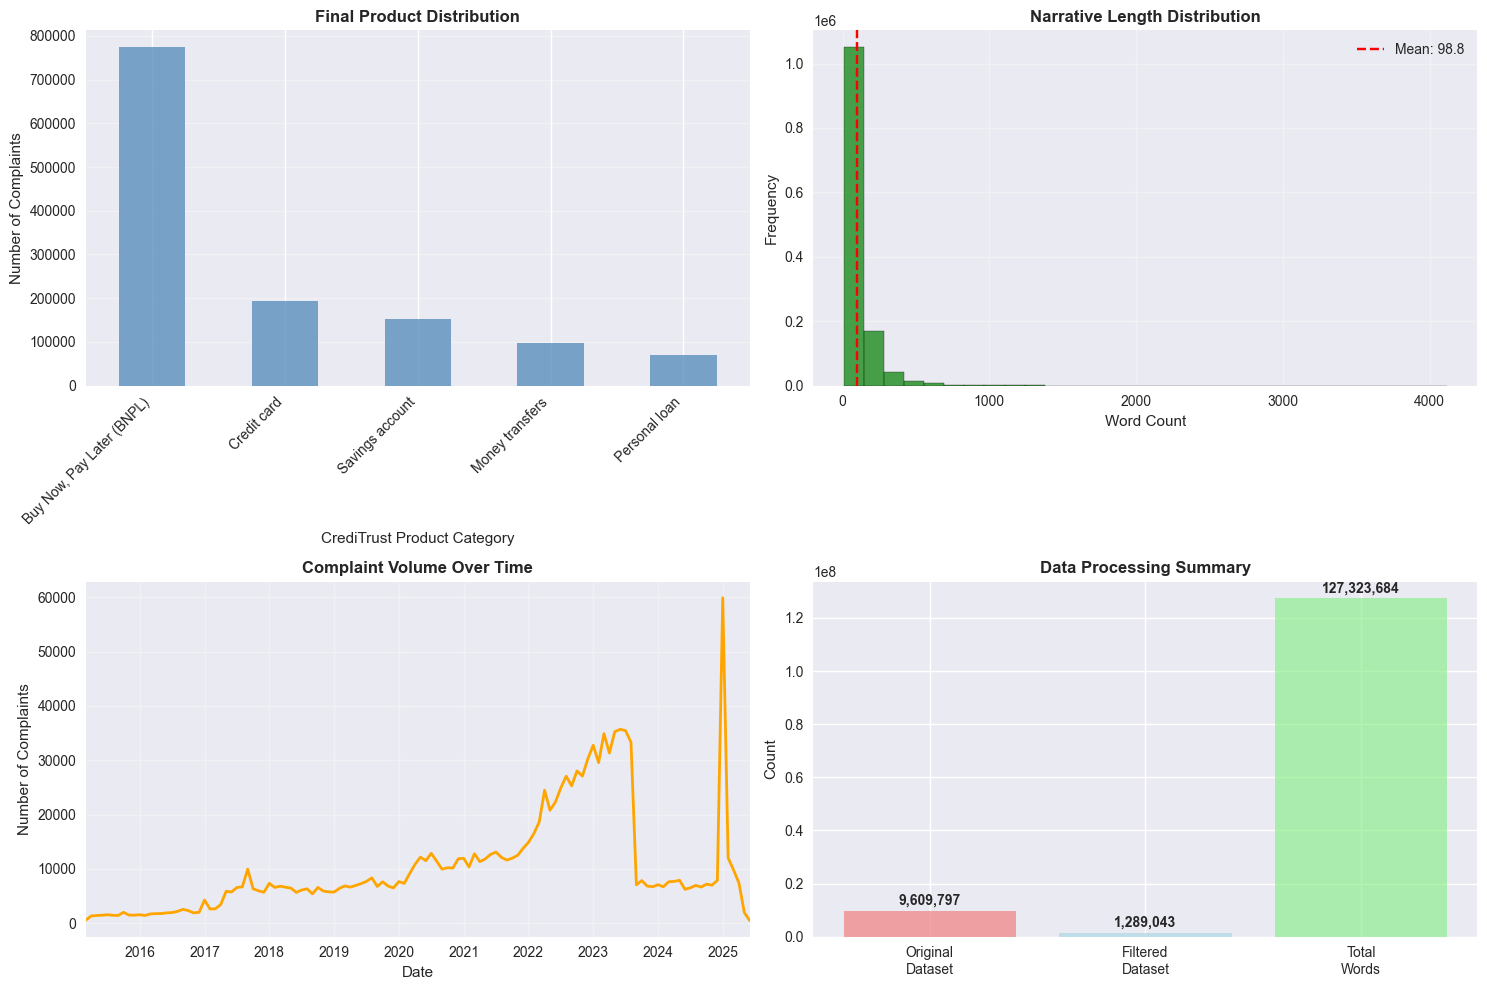


🎉 Task 1- EDA Complete! Ready for Task 2: Text Chunking and Embedding


In [20]:
# Cell 11: Final Summary and Quality Assessment
def generate_final_summary(df_original, df_final):
    """
    Generate comprehensive summary of the data preprocessing pipeline
    """
    print("\n" + "="*80)
    print("📋 FINAL DATA PREPROCESSING SUMMARY")
    print("="*80)
    
    print(f"\n🔄 Data Pipeline Results:")
    print(f"   • Original CFPB dataset: {len(df_original):,} complaints")
    print(f"   • After product filtering: {len(df_final):,} complaints")
    print(f"   • Data retention rate: {(len(df_final)/len(df_original))*100:.2f}%")
    
    print(f"\n🎯 CrediTrust Product Coverage:")
    product_stats = df_final['CrediTrust_Product'].value_counts()
    for product, count in product_stats.items():
        percentage = (count / len(df_final)) * 100
        print(f"   • {product}: {count:,} complaints ({percentage:.2f}%)")
    
    print(f"\n📊 Data Quality Metrics:")
    print(f"   • Complaints with clean narratives: {len(df_final):,}")
    print(f"   • Average narrative length: {df_final['narrative_word_count'].mean():.1f} words")
    print(f"   • Median narrative length: {df_final['narrative_word_count'].median():.1f} words")
    print(f"   • Shortest narrative: {df_final['narrative_word_count'].min()} words")
    print(f"   • Longest narrative: {df_final['narrative_word_count'].max()} words")
    
    # Time coverage
    if 'Date received' in df_final.columns:
        date_range = df_final['Date received'].max() - df_final['Date received'].min()
        print(f"   • Time coverage: {date_range.days} days")
        print(f"   • Date range: {df_final['Date received'].min().strftime('%Y-%m-%d')} to {df_final['Date received'].max().strftime('%Y-%m-%d')}")
    
    print(f"\n✅ Dataset is ready for Task 2: Embedding and Vector Store Creation!")
    print(f"   Next steps:")
    print(f"   • Text chunking strategy implementation")
    print(f"   • Embedding generation using sentence transformers")
    print(f"   • Vector store creation with FAISS/ChromaDB")
    
    # Create final visualization
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Product distribution
    plt.subplot(2, 2, 1)
    product_stats.plot(kind='bar', color='steelblue', alpha=0.7)
    plt.title('Final Product Distribution', fontweight='bold')
    plt.xlabel('CrediTrust Product Category')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Subplot 2: Narrative length distribution
    plt.subplot(2, 2, 2)
    plt.hist(df_final['narrative_word_count'], bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(df_final['narrative_word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_final["narrative_word_count"].mean():.1f}')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.title('Narrative Length Distribution', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Subplot 3: Timeline of complaints
    if 'Date received' in df_final.columns:
        plt.subplot(2, 2, 3)
        monthly_complaints = df_final.set_index('Date received').resample('M').size()
        monthly_complaints.plot(color='orange', linewidth=2)
        plt.title('Complaint Volume Over Time', fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Number of Complaints')
        plt.grid(alpha=0.3)
    
    # Subplot 4: Data quality metrics
    plt.subplot(2, 2, 4)
    quality_metrics = [
        len(df_original),
        len(df_final),
        df_final['narrative_word_count'].sum()
    ]
    labels = ['Original\nDataset', 'Filtered\nDataset', 'Total\nWords']
    colors = ['lightcoral', 'lightblue', 'lightgreen']
    
    bars = plt.bar(labels, quality_metrics, color=colors, alpha=0.7)
    plt.title('Data Processing Summary', fontweight='bold')
    plt.ylabel('Count')
    
    # Add value labels on bars
    for bar, value in zip(bars, quality_metrics):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(quality_metrics)*0.01, 
                f'{value:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return product_stats

final_summary = generate_final_summary(df_raw, df_final)

print("\n🎉 Task 1- EDA Complete! Ready for Task 2: Text Chunking and Embedding")